### 0.导包

导入所需的依赖包：标准库、第三方库、自定义库

In [38]:
# 标准库
import os
import sys
import time
from pprint import pprint

# 第三方库
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as SSIM, peak_signal_noise_ratio as PSNR

# 自定义库
from src.core.Encoder import JP2KEncoder as MYJPEncoder
from src.core.Decoder import JP2KDecoder as MYJPDecoder

from src.config_.path_config import SRC_IMG_ROOT, ENCODED_IMG_ROOT, DECODED_IMG_ROOT


### 1.定义评价指标计算函数

主要评价指标包括PSNR和SSMI值，计算bpp用于绘制PSNR-bpp和SSMI-bpp图。

In [39]:
def bpp(file_size, image_size):
    if len(image_size) == 3:
        h, w, c = image_size
        bpp_value = file_size / (h * w * c)
    else:
        h, w = image_size
        bpp_value = file_size / (h * w)
    return bpp_value

### 2.读取图像文件名列表

In [40]:
KODOK_ROOT = SRC_IMG_ROOT / "kodok"

kodok_list = os.listdir(KODOK_ROOT)
kodok_list = [KODOK_ROOT / filename for filename in kodok_list]

pprint(kodok_list[:5])

[WindowsPath('D:/Project/MyProjects/JP2K_System/img/src_img/kodok/kodim01.png'),
 WindowsPath('D:/Project/MyProjects/JP2K_System/img/src_img/kodok/kodim02.png'),
 WindowsPath('D:/Project/MyProjects/JP2K_System/img/src_img/kodok/kodim03.png'),
 WindowsPath('D:/Project/MyProjects/JP2K_System/img/src_img/kodok/kodim04.png'),
 WindowsPath('D:/Project/MyProjects/JP2K_System/img/src_img/kodok/kodim05.png')]


### 3.从kodok数据集计算绘图数据

求出同一个量化系数下，每张图的压缩后的psnr值、ssmi值、bpp值，然后求平均值

In [41]:
def calculate(img_path, q_factor, encoder=None, decoder=None):
    if encoder is None:
        encoder = MYJPEncoder()
    if decoder is None:
        decoder = MYJPDecoder()
    encoder.q_factor = q_factor
    decoder.q_factor = q_factor

    src_img = encoder.read(img_path)
    
    start = time.time()
    src_bitstream = encoder.encode(src_img)
    encode_time = time.time() - start

    start = time.time()
    decoded_img = decoder.decode(src_bitstream)
    decode_time = time.time() - start

    if src_img.shape[0] != decoded_img.shape[0]:
        decoded_img = np.transpose(decoded_img, (1, 0, 2))

    psnr_value = PSNR(src_img, decoded_img)
    ssim_value = SSIM(src_img, decoded_img, channel_axis=2)
    file_size = sys.getsizeof(src_bitstream)
    bpp_value = bpp(file_size, decoded_img.shape) 
    return bpp_value, psnr_value, ssim_value, encode_time, decode_time

def calculate_jpeg(img_path, quality):
    src_img = Image.open(str(img_path))
    output_path = img_path.parent.parent.parent / "test_img" / f"{img_path.stem}.jpg"
    src_img.save(output_path, 'JPEG', quality=quality)

    src_img = cv2.imread(img_path)
    decoded_img = cv2.imread(output_path)
            
    psnr_value = PSNR(src_img, decoded_img)
    ssim_value = SSIM(src_img, decoded_img, channel_axis=2)
    file_size = os.path.getsize(output_path) * 8
    bpp_value = bpp(file_size, decoded_img.shape)
    return bpp_value, psnr_value, ssim_value, 0, 0

In [42]:
def get_data(path_list, calculate_func, q_factor, **kwargs):
    bpp_list, psnr_list, ssim_list = [], [], []
    encode_times, decode_times = [], []
    for file_path in path_list:
        bpp_v, psnr_v, ssim_v, encode_time, decode_time = calculate_func(file_path, q_factor, **kwargs)
        bpp_list.append(bpp_v)
        psnr_list.append(psnr_v)
        ssim_list.append(ssim_v)
        encode_times.append(encode_time)
        decode_times.append(decode_time)
    return bpp_list, psnr_list, ssim_list, encode_times, decode_times
    

In [43]:
encoder = MYJPEncoder(tile_size=128)
decoder = MYJPDecoder(tile_size=128)

factor_list = range(10, 70, 10)

my_metrics = {
    "bpp": [],
    "psnr": [],
    "ssim": [],
    "encode_time": [],
    "decode_time": []
}

jpeg_metrics = {
    "bpp": [],
    "psnr": [],
    "ssim": [],
    "encode_time": [],
    "decode_time": []
}

def avg(num_list):
    return sum(num_list) / len(num_list)

for q_factor in factor_list:
    # MY
    bpp_list, psnr_list, ssim_list, encode_times, decode_times = get_data(kodok_list, calculate, q_factor, encoder=encoder, decoder=decoder)
    my_metrics["bpp"].append(avg(bpp_list))
    my_metrics["psnr"].append(avg(psnr_list))
    my_metrics["ssim"].append(avg(ssim_list))
    my_metrics["encode_time"].append(avg(encode_times))
    my_metrics["decode_time"].append(avg(decode_times))
    # JPEG
    bpp_list, psnr_list, ssim_list, encode_times, decode_times = get_data(kodok_list, calculate_jpeg, q_factor)
    jpeg_metrics["bpp"].append(avg(bpp_list))
    jpeg_metrics["psnr"].append(avg(psnr_list))
    jpeg_metrics["ssim"].append(avg(ssim_list))
    jpeg_metrics["encode_time"].append(avg(encode_times))
    jpeg_metrics["decode_time"].append(avg(decode_times))

{'bpp': [0.276815343786169,
         0.22627597384982642,
         0.20500988430447045,
         0.19221637867115168,
         0.18432320488823783,
         0.1769852814850984],
 'decode_time': [0.18275929490725198,
                 0.15764128168423971,
                 0.14774995048840842,
                 0.14231520891189575,
                 0.1379899581273397,
                 0.13521568973859152],
 'encode_time': [0.16194202502568564,
                 0.1530076265335083,
                 0.15072885155677795,
                 0.15061426162719727,
                 0.1479617158571879,
                 0.15112486481666565],
 'psnr': [29.958556911953067,
          23.006832226482967,
          24.86174800031033,
          18.75113338410343,
          21.916095859487566,
          19.29306924180589],
 'ssim': [0.7814688941096114,
          0.7188749932652886,
          0.6935612725947421,
          0.6214769646879706,
          0.632305237424888,
          0.5911722451013722]}


In [47]:
pprint(my_metrics)

{'bpp': [0.276815343786169,
         0.22627597384982642,
         0.20500988430447045,
         0.19221637867115168,
         0.18432320488823783,
         0.1769852814850984],
 'decode_time': [0.18275929490725198,
                 0.15764128168423971,
                 0.14774995048840842,
                 0.14231520891189575,
                 0.1379899581273397,
                 0.13521568973859152],
 'encode_time': [0.16194202502568564,
                 0.1530076265335083,
                 0.15072885155677795,
                 0.15061426162719727,
                 0.1479617158571879,
                 0.15112486481666565],
 'psnr': [29.958556911953067,
          23.006832226482967,
          24.86174800031033,
          18.75113338410343,
          21.916095859487566,
          19.29306924180589],
 'ssim': [0.7814688941096114,
          0.7188749932652886,
          0.6935612725947421,
          0.6214769646879706,
          0.632305237424888,
          0.5911722451013722]}


### 4.根据数据绘制PSNR-bpp图和SSIM-bpp图

In [50]:
def draw_psnr(psnr_list, bpp_list,
              psnr_list_2=None, bpp_list_2=None, 
              title='PSNR-bpp', 
              xlabel='Bits per pixel (bpp)', 
              ylabel='PSNR (dB)', 
              xlim=None, 
              ylim=None):
    plt.figure(figsize=(10, 6))
    plt.plot(bpp_list, psnr_list, marker='o', color='b')
    if psnr_list_2 is not None and bpp_list_2 is not None:
        plt.plot(bpp_list_2, psnr_list_2, marker='s', color='r')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)
    plt.grid(True)
    plt.show()

def draw_ssim(ssim_list, bpp_list,
              ssim_list_2=None, bpp_list_2=None,
              title='SSIM-bpp', 
              xlabel='Bits per pixel (bpp)', 
              ylabel='SSIM', 
              xlim=None, 
              ylim=None):
    plt.figure(figsize=(10, 6))
    plt.plot(bpp_list, ssim_list, marker='o', color='b')
    if ssim_list_2 is not None and bpp_list_2 is not None:
        plt.plot(bpp_list_2, ssim_list_2, marker='s', color='r')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)
    plt.grid(True)
    plt.show()

def draw_time(time_list, bpp_list,
              time_list_2=None, bpp_list_2=None,
              title='Time-bpp', 
              xlabel='Bits per pixel (bpp)', 
              ylabel='Time(s)', 
              xlim=None, 
              ylim=None):
    plt.figure(figsize=(10, 6))
    plt.plot(bpp_list, time_list, marker='o', color='b')
    if time_list_2 is not None and bpp_list_2 is not None:
        plt.plot(bpp_list_2, time_list_2, marker='s', color='r')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)
    plt.grid(True)
    plt.show()

绘图：

1. 自定义编码器的bpp、psnr、ssim值
2. JPEG编码的bpp、psnr、ssim值

仅绘制自定义编码器的 PSNR-bpp图 和 SSIM-bpp图

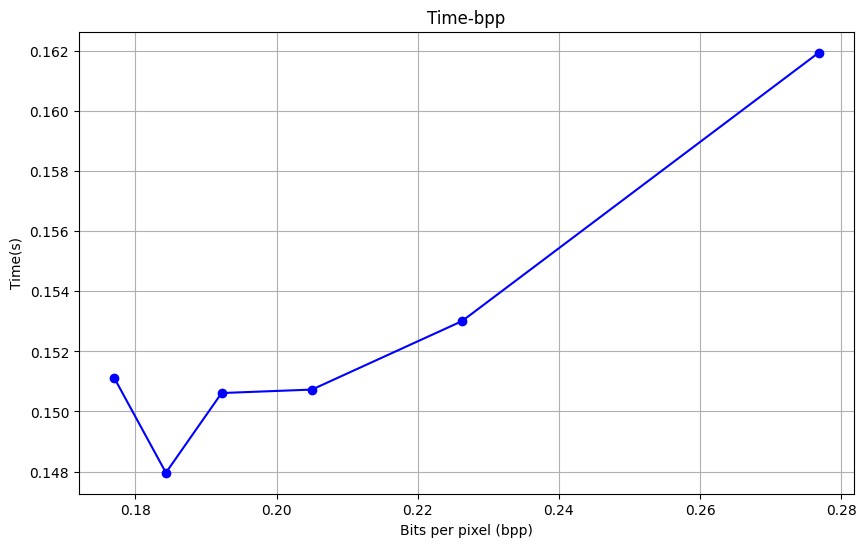

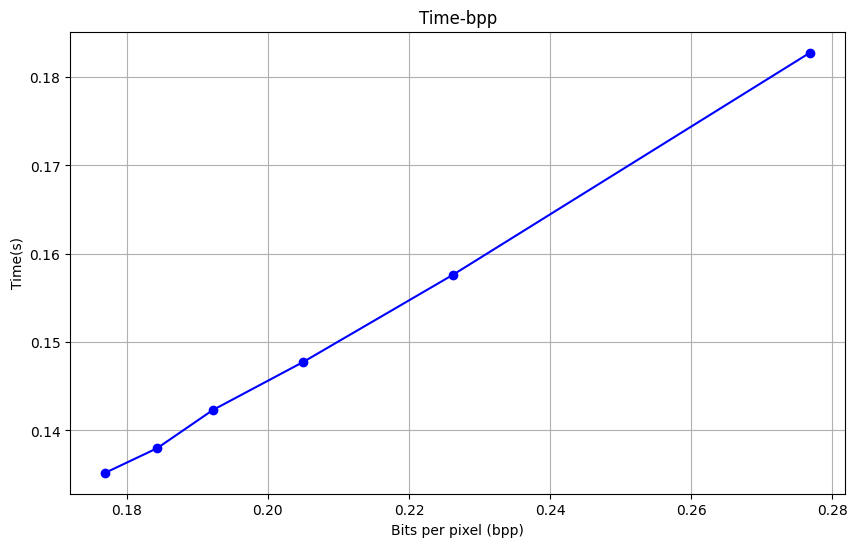

In [52]:
bpp_scale = (max(my_metrics["bpp"]) - min(my_metrics["bpp"]))/4
bpp_lim = (min(my_metrics["bpp"]) - bpp_scale, max(my_metrics["bpp"]) + bpp_scale)

encode_time_scale = (max(my_metrics["encode_time"]) - min(my_metrics["encode_time"]))/4
encode_time_lim = (min(my_metrics["encode_time"]) - encode_time_scale, max(my_metrics["encode_time"]) + encode_time_scale)

decode_time_scale = (max(my_metrics["decode_time"]) - min(my_metrics["decode_time"]))/4
decode_time_lim = (min(my_metrics["decode_time"]) - decode_time_scale, max(my_metrics["decode_time"]) + decode_time_scale)

draw_time(my_metrics["encode_time"], my_metrics["bpp"])
draw_time(my_metrics["decode_time"], my_metrics["bpp"])

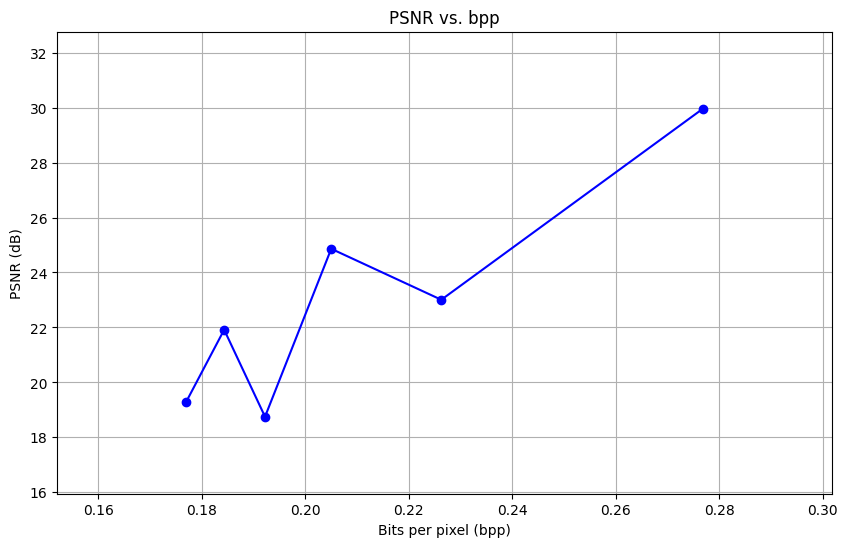

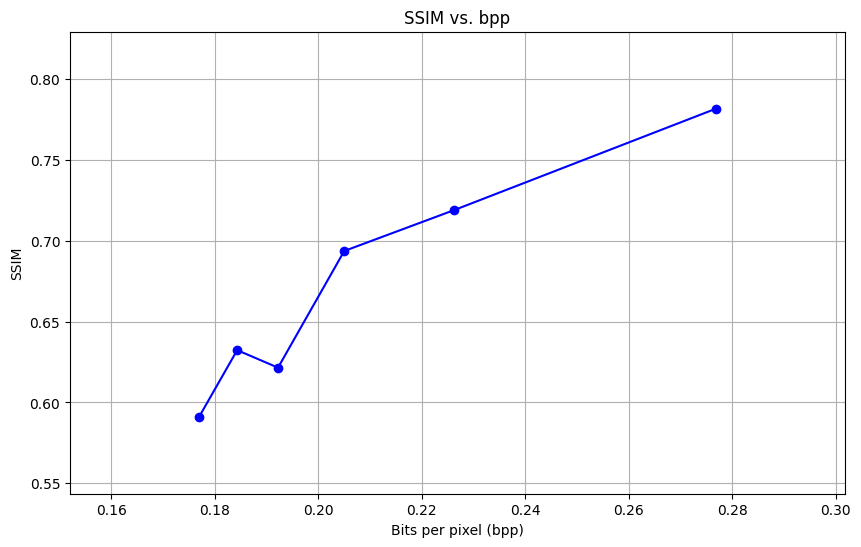

In [48]:
psnr_scale = (max(my_metrics["psnr"]) - min(my_metrics["psnr"]))/4
psnr_lim = (min(my_metrics["psnr"]) - psnr_scale, max(my_metrics["psnr"]) + psnr_scale)

ssim_scale = (max(my_metrics["ssim"]) - min(my_metrics["ssim"]))/4
ssim_lim = (min(my_metrics["ssim"]) - ssim_scale, max(my_metrics["ssim"]) + ssim_scale)

draw_psnr(my_metrics["psnr"], my_metrics["bpp"], xlim=bpp_lim, ylim=psnr_lim)
draw_ssim(my_metrics["ssim"], my_metrics["bpp"], xlim=bpp_lim, ylim=ssim_lim)


同时绘制自定义编码器和JPEG标准的 PSNR-bpp图 和 SSIM-bpp图

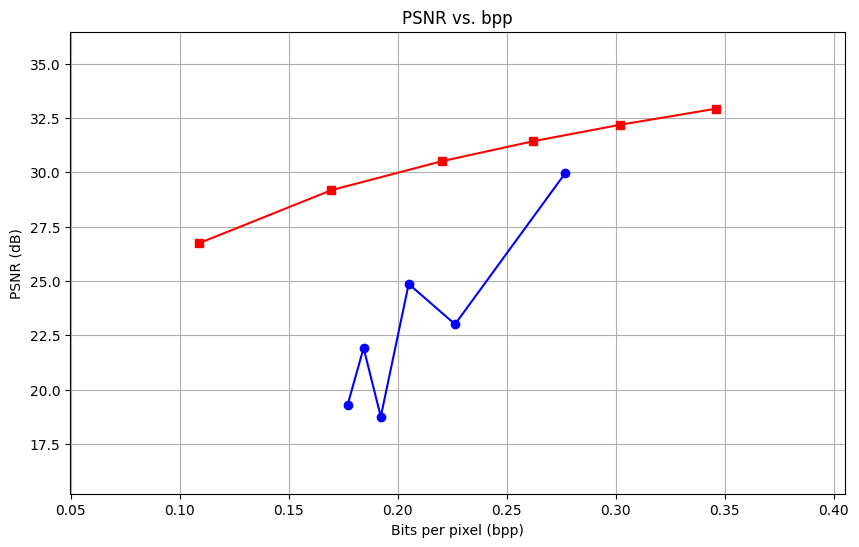

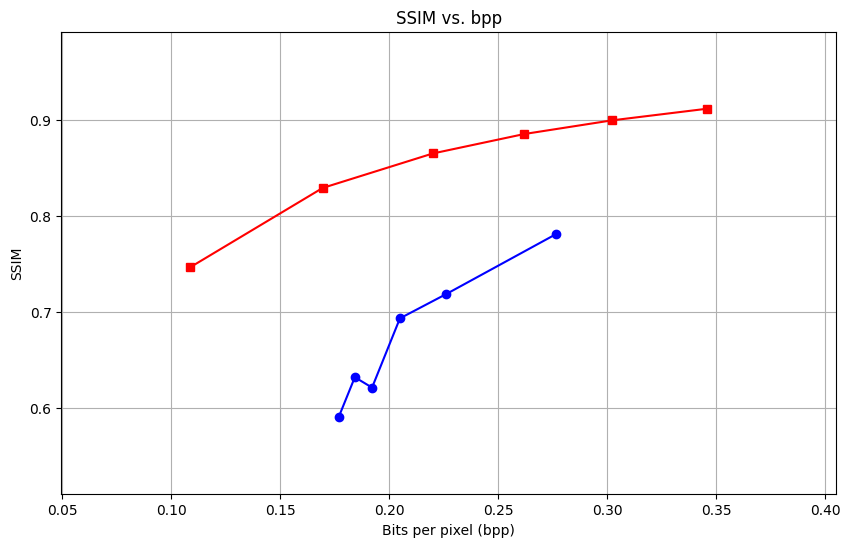

In [49]:
merge_bpp = my_metrics["bpp"] + jpeg_metrics["bpp"]
bpp_scale = (max(merge_bpp) - min(merge_bpp))/4
bpp_lim = (min(merge_bpp)-bpp_scale, max(merge_bpp)+bpp_scale)

merge_psnr = my_metrics["psnr"] + jpeg_metrics["psnr"]
psnr_scale = (max(merge_psnr) - min(merge_psnr))/4
psnr_lim = (min(merge_psnr)-psnr_scale, max(merge_psnr)+psnr_scale)

merge_ssim = my_metrics["ssim"] + jpeg_metrics["ssim"]
ssim_scale = (max(merge_ssim) - min(merge_ssim))/4
ssim_lim = (min(merge_ssim)-ssim_scale, max(merge_ssim)+ssim_scale)

draw_psnr(my_metrics["psnr"], my_metrics["bpp"], jpeg_metrics["psnr"], jpeg_metrics["bpp"], xlim=bpp_lim, ylim=psnr_lim)
draw_ssim(my_metrics["ssim"], my_metrics["bpp"], jpeg_metrics["ssim"], jpeg_metrics["bpp"], xlim=bpp_lim, ylim=ssim_lim)
